In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# SettingWithCopyWarning problem might occur when changing order_datetime to date time, ignore this warning
pd.options.mode.chained_assignment = None

In [2]:
full_data = pd.read_parquet('../data/curated/clean_full_dataset')


In [3]:
transaction_df = full_data[['business_area_type', 'order_datetime']]

In [4]:
transaction_df['order_datetime']= pd.to_datetime(transaction_df['order_datetime'])

In [5]:
transaction_df['month'] = transaction_df['order_datetime'].dt.to_period('M')

In [6]:
transaction_df

,business_area_type,order_datetime,month
0,Manufacturing,2021-08-19,2021-08
1,Manufacturing,2021-08-08,2021-08
2,Manufacturing,2021-08-12,2021-08
3,Manufacturing,2021-05-19,2021-05
4,Manufacturing,2021-06-10,2021-06
...,...,...,...
12123001,Retail trade,2022-05-27,2022-05
12123002,Retail trade,2022-08-24,2022-08
12123003,Retail trade,2021-12-29,2021-12
12123004,Retail trade,2021-10-30,2021-10


In [7]:
# count number of transactions in each business area
business_transaction_count = transaction_df.groupby(['business_area_type',"month"]).count()

In [8]:
business_transaction_count

order_datetime
business_area_type           month                  
Arts and recreation services 2021-02              18
                             2021-03             833
                             2021-04             814
                             2021-05             942
                             2021-06             939
...                                              ...
Retail trade                 2022-04          496021
                             2022-05          559983
                             2022-06          553204
                             2022-07          581477
                             2022-08          607418

[114 rows x 1 columns]

In [10]:
# rename order datetime to Monthly count
business_transaction_count = business_transaction_count.rename(columns = {'order_datetime': 'Monthly Count'})

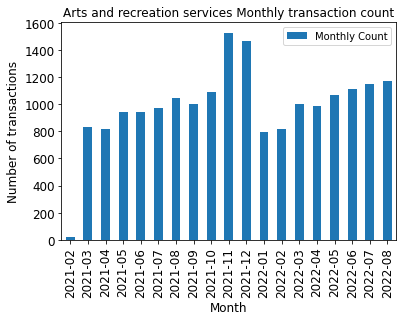

In [14]:
Arts = business_transaction_count.loc[["Arts and recreation services"]].reset_index(level=0, drop=True)

arts = Arts[['Monthly Count']].plot(kind='bar', \
                            title = "Arts and recreation services Monthly transaction count", fontsize=12)

arts.set_xlabel("Month", fontsize=12)
arts.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Arts_and_recreation_services_Monthly_transaction.png', bbox_inches='tight')

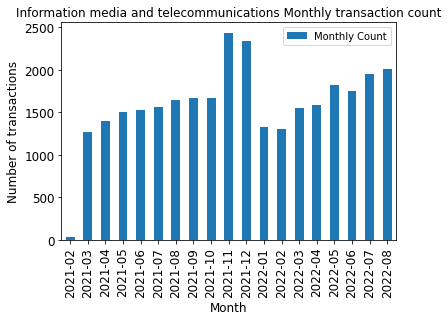

In [15]:
Info_teli = business_transaction_count.loc[["Information media and telecommunications"]]\
                .reset_index(level=0, drop=True)
info_teli = Info_teli[['Monthly Count']].plot(kind='bar', \
                title ="Information media and telecommunications Monthly transaction count", fontsize=12)
info_teli.set_xlabel("Month", fontsize=12)
info_teli.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Information_media_and_telecommunications_Monthly_transaction.png', 
            bbox_inches='tight')


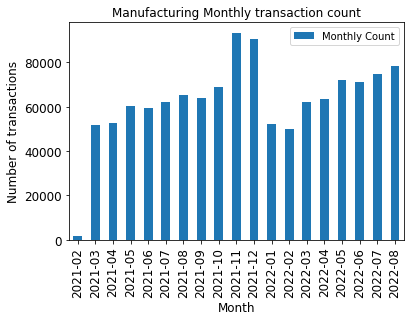

In [16]:
Manufacture = business_transaction_count.loc[["Manufacturing"]].reset_index(level=0, drop=True)
manufacture = Manufacture[['Monthly Count']].plot(kind='bar', \
                        title ="Manufacturing Monthly transaction count", fontsize=12)
manufacture.set_xlabel("Month", fontsize=12)
manufacture.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Manufacturing_Monthly_transaction.png', bbox_inches='tight')


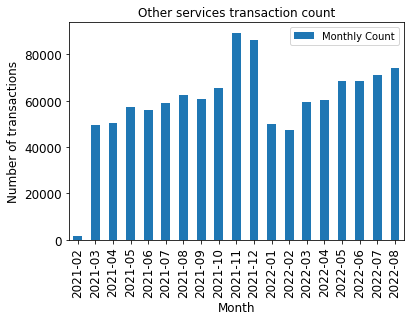

In [17]:
Other = business_transaction_count.loc[["Other services"]].reset_index(level=0, drop=True)
other = Other[['Monthly Count']].plot(kind='bar', title ="Other services transaction count", fontsize=12)
other.set_xlabel("Month", fontsize=12)
other.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Other_services_Monthly_transaction.png', bbox_inches='tight')


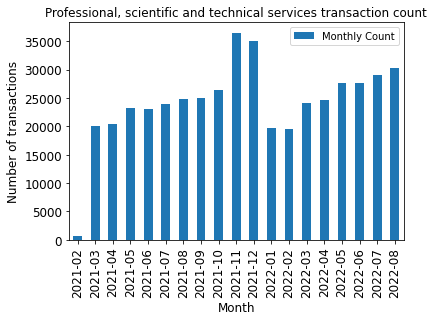

In [18]:
Professional = business_transaction_count.loc[["Professional, scientific and technical services"]]\
                .reset_index(level=0, drop=True)
pro_sci_tech = Professional[['Monthly Count']] \
    .plot(kind='bar', title ="Professional, scientific and technical services transaction count", fontsize=12)
pro_sci_tech.set_xlabel("Month", fontsize=12)
pro_sci_tech.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Professional_services_Monthly_transaction.png', bbox_inches='tight')


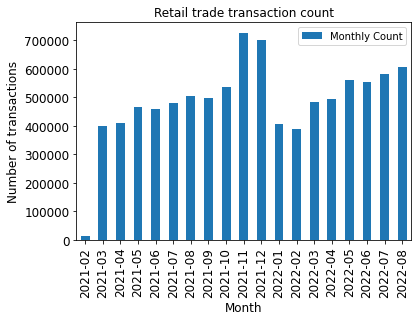

In [19]:
Retail = business_transaction_count.loc[["Retail trade"]].reset_index(level=0, drop=True)
retail = Retail[['Monthly Count']] \
    .plot(kind='bar', title ="Retail trade transaction count", fontsize=12)
retail.set_xlabel("Month", fontsize=12)
retail.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Retail_Monthly_transaction.png', bbox_inches='tight')
